In [44]:
%matplotlib inline
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ipywidgets as widgets
import datetime
import seaborn as sns
import scipy
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from ipywidgets import interact, interact_manual
import dateutil.parser
import time

from collections import OrderedDict
from tqdm.notebook import tqdm

import geopandas as gpd

https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/qtlnjy1vacjn98x/keplergl_zrjd9w7.json

In [3]:
# data_geo = geopandas.read_file('../data/reservoir-locations.geojson')
# dir_time_series = '../data/time_series_monthly/'

In [45]:
data_geo = gpd.read_file('../data/time_series_2021.Q1_locations_final.geojson')
dir_time_series = '../data/wps-reservoir-time-series-latest/time_series_area_monthly/'

In [3]:
data_geo

,id,fid,area,geometry
0,0,1,2.719809e+03,POINT (-84.09430 30.86247)
1,0,2,3.539250e+03,POINT (-7.39246 38.07846)
2,0,3,4.067218e+03,POINT (116.01598 -33.97824)
3,0,4,6.402755e+03,POINT (143.30967 -37.51832)
4,0,5,6.286617e+03,POINT (57.09872 29.46726)
...,...,...,...,...
71203,0,92429,6.045185e+09,POINT (-0.76711 8.59025)
71204,0,92430,6.969213e+09,POINT (31.76161 22.42694)
71205,0,92438,6.957402e+09,POINT (27.81359 -17.03009)
71206,0,92471,1.690009e+05,POINT (44.07674 2.78729)


In [28]:
# compute inter- and intra- annual variance (SD)
data_geo['sd_intra'] = 0
data_geo['sd_inter'] = 0
data_geo['rsd_intra'] = 0
data_geo['rsd_inter'] = 0
data_geo['mean'] = 0
data_geo['median'] = 0

# percentiles = range(0, 105, 5)
# for p in percentiles:
#     data_geo['percentile' + str(p)] = -1
    
for i, row in tqdm(list(data_geo.iterrows())):
    path = pathlib.Path(dir_time_series) / f'{str(row.fid).zfill(7)}.csv'
    
    if not os.path.exists(path):
        continue
    
    df = pd.read_csv(path)
    df.index = df.time.apply(lambda t: dateutil.parser.parse(t))
    
    df = df[df.time > '2000-01-01']
    
    mean = df.area.mean()
    median = df.area.median()
    
    try:
        res = STL(df['area'], trend=int(12*3)+1, seasonal=7, period=12).fit()
        row['sd_intra'] = res.seasonal.std()
        row['sd_inter'] = res.trend.std()
        row['mean'] = mean
        row['median'] = median

        if median != 0:
            row['rsd_intra'] = res.seasonal.std() / mean
            row['rsd_inter'] = res.trend.std() / mean

        data_geo.iloc[i] = row
    except:
        print('Error: ' + path)


In [29]:
data_geo.head()

,fid,geometry,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter
0,1,POINT (-84.09430 30.86247),253.248208,290.020795,108.903678,8.219545e-14,0.430027,3.245648e-16
1,2,POINT (-7.39246 38.07846),683.026927,593.590036,142.398724,1.349888e+02,0.208482,1.976332e-01
2,3,POINT (116.01598 -33.97824),1456.371598,1436.514874,104.405335,2.249065e+02,0.071689,1.544293e-01
3,4,POINT (143.30967 -37.51832),1492.241636,1131.187688,751.385087,3.301308e+02,0.503528,2.212315e-01
4,5,POINT (57.09872 29.46726),1097.426088,749.178918,370.148673,4.794100e+02,0.337288,4.368495e-01


In [30]:
data_geo.columns

Index(['fid', 'geometry', 'mean', 'median', 'sd_intra', 'sd_inter',
       'rsd_intra', 'rsd_inter'],
      dtype='object')

In [31]:
data_geo = data_geo[['fid', 'geometry', 'mean', 'median', 'sd_intra', 'sd_inter', 'rsd_intra', 'rsd_inter']]

In [32]:
data_geo.head()

,fid,geometry,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter
0,1,POINT (-84.09430 30.86247),253.248208,290.020795,108.903678,8.219545e-14,0.430027,3.245648e-16
1,2,POINT (-7.39246 38.07846),683.026927,593.590036,142.398724,1.349888e+02,0.208482,1.976332e-01
2,3,POINT (116.01598 -33.97824),1456.371598,1436.514874,104.405335,2.249065e+02,0.071689,1.544293e-01
3,4,POINT (143.30967 -37.51832),1492.241636,1131.187688,751.385087,3.301308e+02,0.503528,2.212315e-01
4,5,POINT (57.09872 29.46726),1097.426088,749.178918,370.148673,4.794100e+02,0.337288,4.368495e-01


In [33]:
data_geo.to_file("../data/reservoir-locations-2021-Q1-stats.geojson", driver='GeoJSON')

In [34]:
data_geo.to_file("../data/wps-reservoir-time-series-latest/shp/reservoirs-locations-v1.0.shp")

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> THE END OF UPDATE CODE <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [66]:
data_geo = gpd.read_file("../data/reservoir-locations-2021-Q1-stats.geojson")

In [67]:
data_geo['mean'].values

array([2.53248208e+02, 6.83026927e+02, 1.45637160e+03, ...,
       3.75660470e+09, 4.87426534e+04, 1.95273560e+06])

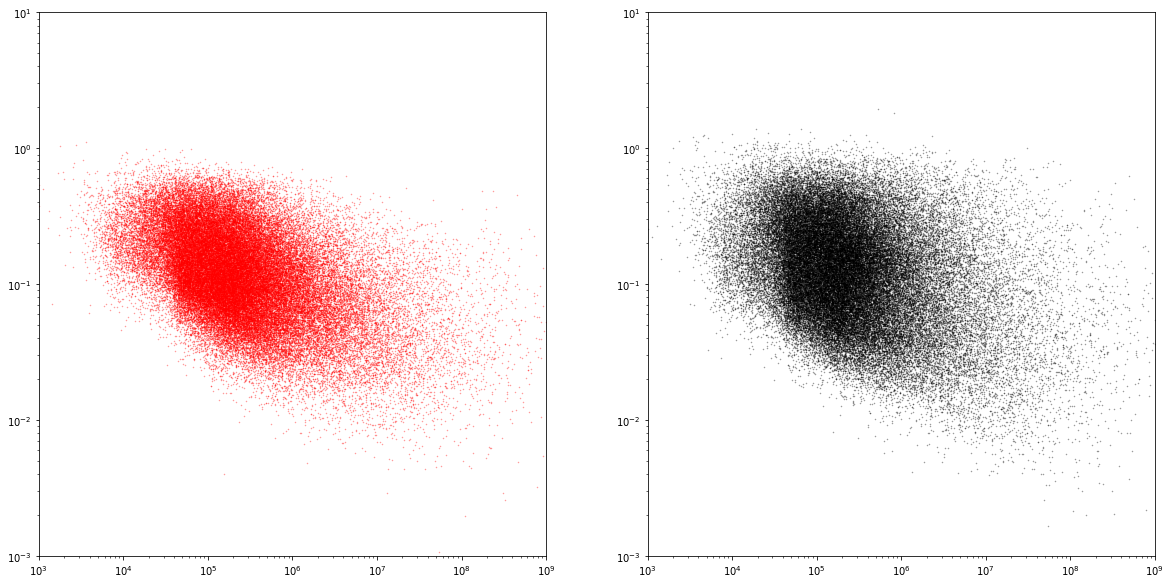

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
d = data_geo
ax1.plot(d['median'].values, d['rsd_intra'].values, 'r.', markersize=1, alpha=0.4)
ax2.plot(d['median'].values, d['rsd_inter'].values, 'k.', markersize=1, alpha=0.4)
ax1.set_ylim(ymin=1e-3, ymax=1e1)
ax2.set_ylim(ymin=1e-3, ymax=1e1)

ax1.set_xlim(xmin=1e3, xmax=1e9)
ax2.set_xlim(xmin=1e3, xmax=1e9)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

In [65]:
d.columns

Index(['id', 'fid', 'area', 'geometry'], dtype='object')

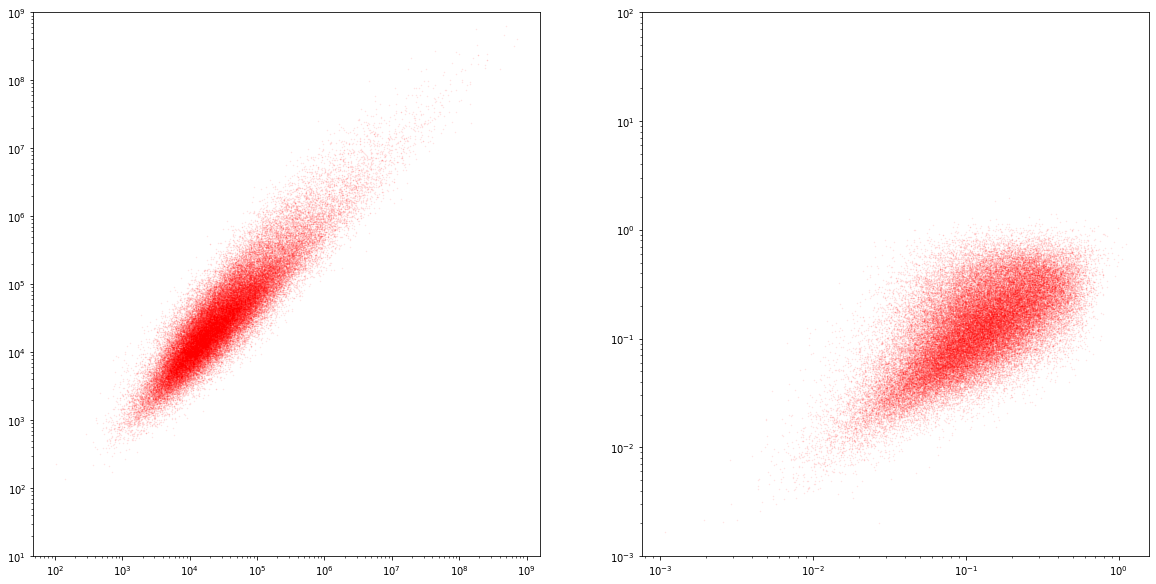

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
d = data_geo
ax1.plot(d['sd_intra'].values, d['sd_inter'].values, 'r.', markersize=1, alpha=0.1)
ax1.set_xscale('log')
ax1.set_yscale('log')

# ax1.set_xlim(xmin=1e3, xmax=1e9)
ax1.set_ylim(ymin=1e1, ymax=1e9)
# ax2.set_xlim(xmin=1e3, xmax=1e9)
ax2.set_ylim(ymin=1e-3, ymax=1e2)

ax2.plot(d['rsd_intra'].values, d['rsd_inter'].values, 'r.', markersize=1, alpha=0.1)
ax2.set_xscale('log')
ax2.set_yscale('log')


## Get by country

In [46]:
reservoirs_and_country_basin = gpd.read_file(r'..\data\wps-reservoir-time-series-latest\shp\extra\reservoirs-v1.0-and-countries-basins.shp')

In [59]:
reservoirs_and_country_basin = reservoirs_and_country_basin[reservoirs_and_country_basin.country_na.notna()]

In [87]:
fids = reservoirs_and_country_basin[reservoirs_and_country_basin.country_na.str.contains("South Africa")].fid

d = data_geo[data_geo.fid.isin(fids)]

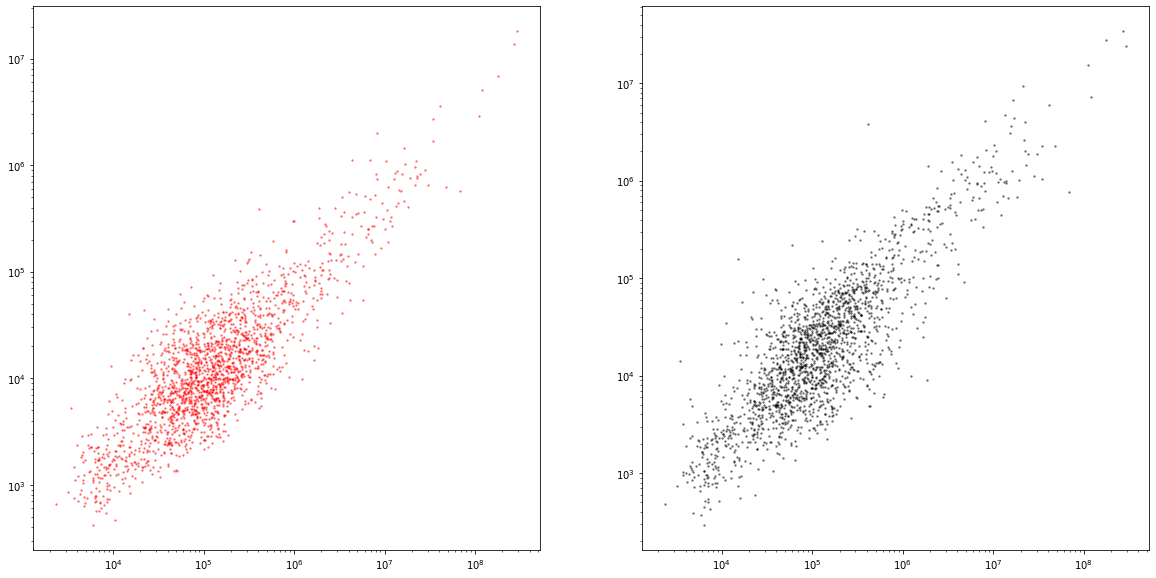

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(d['median'].values, d['sd_intra'].values, 'r.', markersize=3, alpha=0.4)
ax2.plot(d['median'].values, d['sd_inter'].values, 'k.', markersize=3, alpha=0.4)
# ax1.set_ylim(ymin=1e-3, ymax=1e1)
# ax2.set_ylim(ymin=1e-3, ymax=1e1)
# ax1.set_xlim(xmin=1e3, xmax=1e9)
# ax2.set_xlim(xmin=1e3, xmax=1e9)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

In [9]:
files = pathlib.Path('../data/time_series_monthly').glob(step)
list(files)[:10]

[WindowsPath('../data/time_series_monthly/water_area_00013.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00014.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00015.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00016.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00017.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00020.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00021.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00025.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00026.csv'),
 WindowsPath('../data/time_series_monthly/water_area_00027.csv')]

In [33]:
path = '../data/time_series_monthly/' + pathlib.Path(data_geo.iloc[80000].filename).stem + '.csv'
path

'../data/time_series_monthly/water_area_00073.csv'

In [34]:
df = pd.read_csv(path)
df

,time,area
0,1985-03-31,612565.153468
1,1985-04-30,580251.531270
2,1985-05-31,570440.670589
3,1985-06-30,593792.056367
4,1985-07-31,675560.781134
...,...,...
395,2018-02-28,329479.016366
396,2018-03-31,354410.266197
397,2018-04-30,361191.209360
398,2018-05-31,359828.646002


<AxesSubplot:>

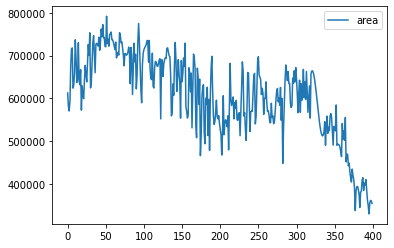

In [35]:
df.plot()


In [36]:
df.index = df.time.apply(lambda t: dateutil.parser.parse(t))

In [37]:
df

,time,area
time,,
1985-03-31,1985-03-31,612565.153468
1985-04-30,1985-04-30,580251.531270
1985-05-31,1985-05-31,570440.670589
1985-06-30,1985-06-30,593792.056367
1985-07-31,1985-07-31,675560.781134
...,...,...
2018-02-28,2018-02-28,329479.016366
2018-03-31,2018-03-31,354410.266197
2018-04-30,2018-04-30,361191.209360


In [38]:
res = STL(df['area'], trend=int(12*1.5) + 1, seasonal=7).fit()
intra_annual = res.seasonal.std()
inter_annual = res.trend.std()

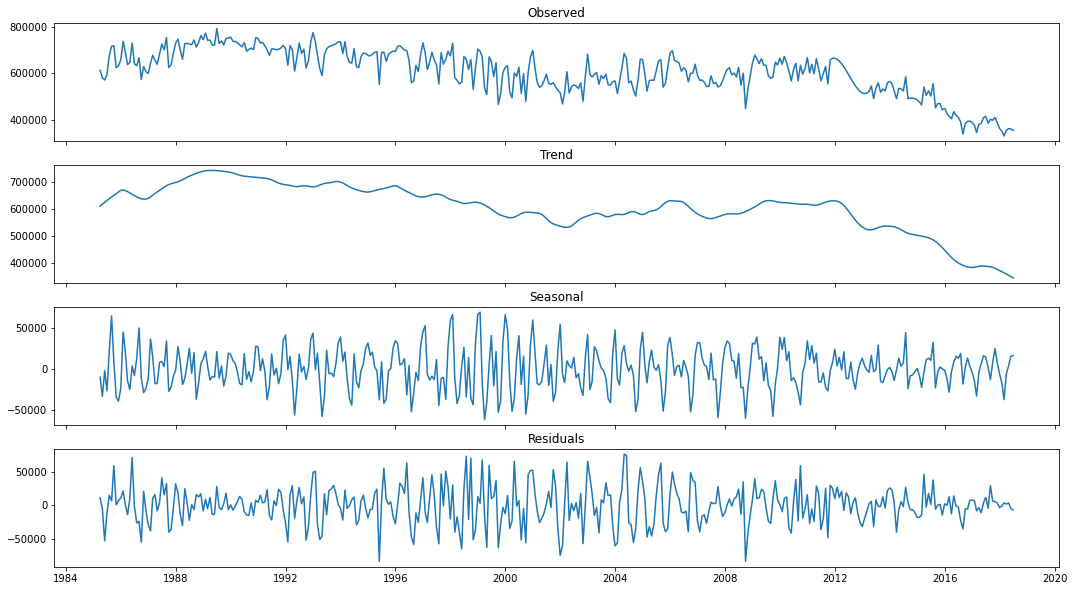

In [39]:
fig, ax = plt.subplots(4, 1, figsize=(18,10), sharex=True)

ax[0].plot(res.observed)
ax[0].set_title('Observed')
ax[1].plot(res.trend)
ax[1].set_title('Trend')
ax[2].plot(res.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(res.resid)
ax[3].set_title('Residuals')

plt.show()